## Imports

In [1]:
print('')

In [53]:
import os
import math
import obspy
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from datetime import timedelta
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from earthquake import Earthquake
import util
import pandas as pd
import random

## Get set up
Set path to data, and read eq_list (all folders in root folder)

## the action!!
For all events with data, load their object . add tp_max and tc  to lists (for plotting)

In [3]:
list_tpmax = []
list_mags = []
list_mag_types = []
list_eq = []
eqs = {}
count = 0

In [4]:
parameters = [
[1,0.1,19,0.5,'eq_object_1s_bandpass_01_19_snr_20'],
[2,0.1,19,0.5,'eq_object_2s_bandpass_01_19_snr_20'],
[3,0.1,19,0.5,'eq_object_3s_bandpass_01_19_snr_20'],
[4,0.1,19,0.5,'eq_object_4s_bandpass_01_19_snr_20']]
#[1,0.1,19,0,'eq_object_1s_bandpass_01_19_snr_20_blank_0'],
#[1,0.1,19,0.05,'eq_object_1s_bandpass_01_19_snr_20_blank_005'],
#[1,0.1,19,0.1,'eq_object_1s_bandpass_01_19_snr_20_blank_01'],
#[1,0.1,19,0.25,'eq_object_1s_bandpass_01_19_snr_20_blank_025'],
#[1,0.1,19,0.5,'eq_object_1s_bandpass_01_19_snr_20_blank_05'],
#[4,0.1,19,0,'eq_object_4s_bandpass_01_19_snr_20_blank_0'],
#[4,0.1,19,0.05,'eq_object_4s_bandpass_01_19_snr_20_blank_005'],
#[4,0.1,19,0.1,'eq_object_4s_bandpass_01_19_snr_20_blank_01'],
#[4,0.1,19,0.25,'eq_object_4s_bandpass_01_19_snr_20_blank_025'],
#[4,0.1,19,0.5,'eq_object_4s_bandpass_01_19_snr_20_blank_05']]

In [5]:
import time

In [13]:
list_tpmax

[[],
 [],
 [],
 [0.3898204198687617,
  0.5109937697543524,
  0.20794469503998395,
  0.8672162046507275,
  0.14151477160926115,
  0.13458673337919158,
  0.26927681611415427,
  0.18873998633035968]]

In [71]:
t_os, t_try, t_plot = [],[],[]
n_list = [50,100,150,200,250,500, 1000]

In [45]:
t_os

[0.3214951800182462,
 0.4492702600546181,
 0.9048469320405275,
 1.2556370999664068,
 1.629324896959588,
 5.851555808912963,
 37.5230935360305,
 0.6877681210171431,
 1.682464119978249,
 5.4314654839690775,
 4.061554164160043,
 6.412471981951967,
 25.077662150142714,
 55.1060909780208]

In [44]:
t_plot

[1.546333918115124,
 1.5662885340861976,
 1.538349332055077,
 1.5793693901505321,
 1.5978958490304649,
 1.8174830439966172,
 2.146939978003502,
 1.643240393139422,
 1.6368454620242119,
 1.7790302368812263,
 1.6582752158865333,
 1.8183036791160703,
 2.4059153590351343,
 2.7348921899683774]

In [ ]:
WINDOW_LENGTH = 1

In [ ]:
def model_function(x_data, a, b):
    return 10**(a*x_data + b)
def model_function_2(x_data, a, b):
    return a*x_data + b


In [87]:
def plot_for_params(list_mags, list_tpmax):
    %matplotlib inline
    params = []
    opacities = np.linspace(0.2,1,45)
    import matplotlib.pyplot as plt
    cs = ['midnightblue']#'#00a1c1']
    #fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    y_aves_tp = []
    x_aves_tp = []
    count = 1
    eq_count = 0
    medians = [[] for _ in range(0, 45)]
    medians_of_medians = [[] for _ in range(0, 45)]
    n = 0
    median_absolute_deviation = []
    sum_absolute_deviation = []
    all_abs_deviation = []
    for n in [1]:#range(1, 10):#number of stations eq at least measured at
        med_for_ad = []
        mag_for_ad = []
        fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
        for mag_lim in [3.4]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
            print(time.perf_counter()) 
            y_aves_tp = []
            x_aves_tp = []
            for i  in range(0, len(list_mags)):

                if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                    if len(list_tpmax[i])>=n:
                        mean_tp = np.mean(list_tpmax[i]) 
                        std_tp = np.std(list_tpmax[i]) 
                        y_tp = [] 
                        for j in list_tpmax[i]: 
                            if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                                y_tp.append(math.log(j, 10))
                            elif len(list_tpmax[i])==1:
                                y_tp.append(math.log(j, 10))
                        x_tp = np.zeros(len(y_tp))  
                        x_tp = x_tp + list_mags[i]
                        c = 0
                        if len(x_tp)>0 and mag_lim == 3.4:
                            if math.isnan(np.median(y_tp))==False:
                                axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 50, c = cs[c], marker = '^', zorder =110, alpha = 0.5)
                            medians[int(np.round(x_tp[0],1)*10)-30].append(y_tp)
                            med_for_ad.append(np.median(y_tp))
                            mag_for_ad.append(list_mags[i])
                        if math.isnan(np.median(y_tp))==False:  
                            y_aves_tp.append(np.median(y_tp))
                            medians_of_medians[int(np.round(x_tp[0],1)*10)-30].append(np.median(y_tp))
                            x_aves_tp.append(list_mags[i])
            if len(y_aves_tp)>0:
                popt, pcov = curve_fit(model_function_2, x_aves_tp, y_aves_tp)
                params.append([popt, len(x_aves_tp)])
                print(mag_lim, popt)

                x_use = np.array(x_aves_tp) - 5
                y_use = np.array(y_aves_tp)

                if str(mag_lim) == str(3.4):
                    popt, pcov = curve_fit(model_function_2, x_use, y_use, absolute_sigma = True)
                    axs.plot(np.array(x_use), model_function_2(np.array(x_use), *popt), color='orange', zorder =100)
                    popt_final, pcov_final = popt, pcov

                print(len(x_aves_tp), len(y_aves_tp))
                count += 1
        try:
            med = []
            med_x = []
            med2 = []
            xs = np.arange(3,7.5,0.1)-5
            for i in range(0, len(medians_of_medians)):
                med.append(np.median(medians_of_medians[i]))
                if len(medians_of_medians[i])>0:
                    med_x.append(xs[i])
                    med2.append(np.median(medians_of_medians[i]))
            popt, pcov = popt_final, pcov_final
            perr = np.sqrt(np.diag(pcov))
            print(popt, perr)
            x_me = np.arange(0, 7.2, 0.1)
            x_lower_me = x_me - perr[1]*2
            x_upper_me =  x_me + perr[1]*2
            y_me = popt[0]*x_me+popt[1]
            y_lower_me = popt[0]*x_lower_me-popt[1]
            y_upper_me = popt[0]*x_upper_me-popt[1]

            a = popt[0]
            a_true = a
            b = popt[1]
            b_true = b
            std_a = perr[0]
            std_b = perr[1]
            x_me = np.arange(3, 7.2, 0.1)-5
            y_1 = (a+std_a)*x_me + (b+std_b)
            y_2 = (a+std_a)*x_me + (b-std_b)
            y_3 = (a-std_a)*x_me + (b+std_b)
            y_4 = (a-std_a)*x_me + (b-std_b)

            y_min = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
            y_max = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))

            axs.set_xlabel("magnitude", fontsize = 14) 

            axs.set_ylabel("log(tp_max)", fontsize = 14) 
            axs.tick_params(axis='both', which='major', labelsize=14)
            axs.tick_params(axis='both', which='minor', labelsize=14)
            olsen_x = np.arange(3,7,0.1)
            olsen_y = 0.14*(olsen_x-5) - 0.83
            axs.plot(olsen_x-5, olsen_y)

            fig.suptitle(str(n)+ " --- window = "+str(WINDOW_LENGTH))

        except Exception:
            print('wrong')

        point_indices = np.array(mag_for_ad)*10-30
        absolute_deviation = []
        for ind in range(0, len(point_indices)):
            absolute_deviation.append(abs(10**med_for_ad[int(ind)]-(10**y_me[int(point_indices[ind])])))
        print(len(absolute_deviation))
        all_abs_deviation.append(absolute_deviation)
        sum_absolute_deviation.append(np.sum(absolute_deviation))
        median_absolute_deviation.append(np.median(absolute_deviation))
        x = x_me
        eigenvalues, eigenvectors = np.linalg.eig(pcov)
        theta = np.linspace(0, 2*np.pi, 1000);
        ev_95 = np.sqrt(5.99)*np.array([np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])])
        ellipsis_95 = (ev_95 * eigenvectors) @ [np.sin(theta), np.cos(theta)]
        for i in range(0, ellipsis_95.shape[1]):
            b_95 ,a_95 = ellipsis_95[:,i]
            axs.plot(x, (a_95+a_true)*x + (b_95+b_true), color = '#ffb253', alpha = 0.2, zorder = 100)
        for i in range(0, ellipsis_95.shape[1]):
            b_95 ,a_95 = ellipsis_95[:,i]
            axs.plot(x, (2*a_95+a_true)*x + (2*b_95+b_true), color = '#f7e6d6', alpha = 0.1, zorder = 100)
        axs.plot(x, popt[0]*x + popt[1], color = '#ff9500', zorder = 105, alpha = 1)
        axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
        #plt.show()
        axs.set_ylim([-2,1])
        plt.show()
    #plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/tp_and_tc/different_station_numbers/1s_bandpass_n_stations_'+str(n)+'_plus_shading_based_on_34_plus.png')

In [95]:
fn

'eq_object_1s_bandpass_01_19_snr_20'

In [94]:
folders

['20180131_020031.a',
 '20180130_192419.a',
 '20180129_162553.a',
 '20180128_101126.a',
 '20180126_104345.a',
 '20180125_172434.a',
 '20180125_163943.a',
 '20180124_105119.a',
 '20180124_074605.a',
 '20180123_173830.a',
 '20180123_063454.a',
 '20180121_190602.a',
 '20180121_010642.a',
 '20180120_113114.a',
 '20180119_161742.a',
 '20180118_174839.a',
 '20180118_145844.a',
 '20180117_225659.a',
 '20180116_150353.a',
 '20180115_081823.a',
 '20180115_063150.a',
 '20180115_022834.a',
 '20180111_184259.a',
 '20180111_182838.a',
 '20180111_182624.a',
 '20180111_170318.a',
 '20180110_051211.a',
 '20180110_031644.a',
 '20180110_010350.a',
 '20180108_140947.a',
 '20180107_085529.a',
 '20180106_183509.a',
 '20180106_153943.a',
 '20180105_155414.a',
 '20180102_205938.a',
 '20180102_042417.a',
 '20180226_133453.a',
 '20180224_100233.a',
 '20180222_072140.a',
 '20180222_071927.a',
 '20180221_234456.a',
 '20180220_093859.a',
 '20180219_103836.a',
 '20180219_065701.a',
 '20180219_053852.a',
 '20180218

1194442.480442244
1194442.483642324
try 50 11.186183508951217
os 50 23.087219197070226
3.4 [ 0.34583289 -2.12083925]
19 19
[ 0.34583288 -0.3916748 ] [0.31676171 0.28958838]
19


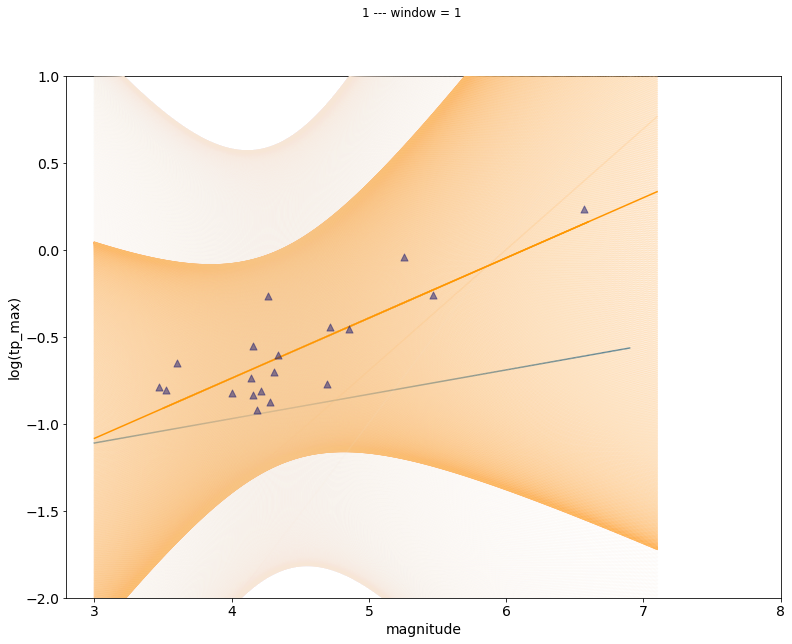

50 1.9537151681724936
1194478.718842085
1194478.72012169
try 100 41.48116284189746
os 100 45.59085889090784
3.4 [ 0.1588854  -1.24302601]
45 45
[ 0.1588854  -0.44859899] [0.24923846 0.20642202]
45


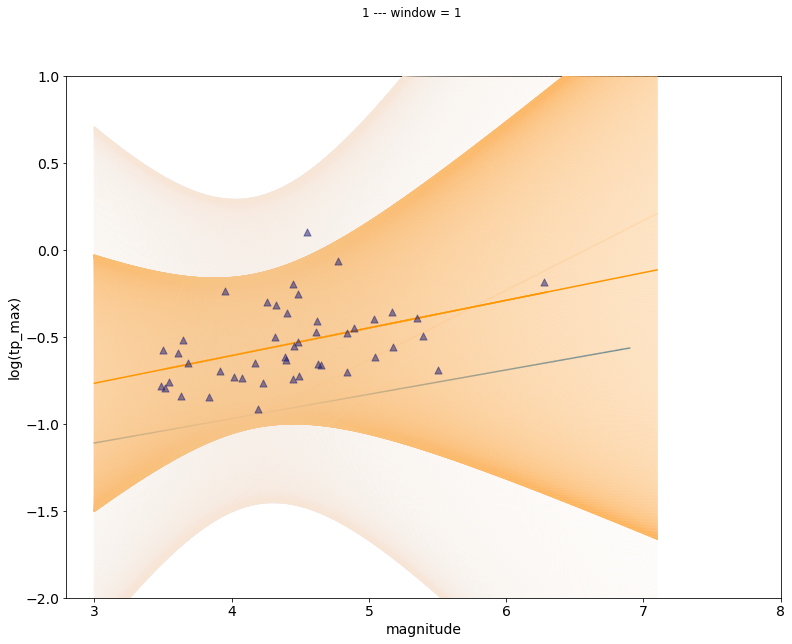

100 2.3065287000499666
1194568.107887962
1194568.109707056
try 150 68.69789659208618
os 150 77.99705386790447
3.4 [ 0.26743083 -1.71426848]
60 60
[ 0.26743083 -0.37711435] [0.25638651 0.24805952]
60


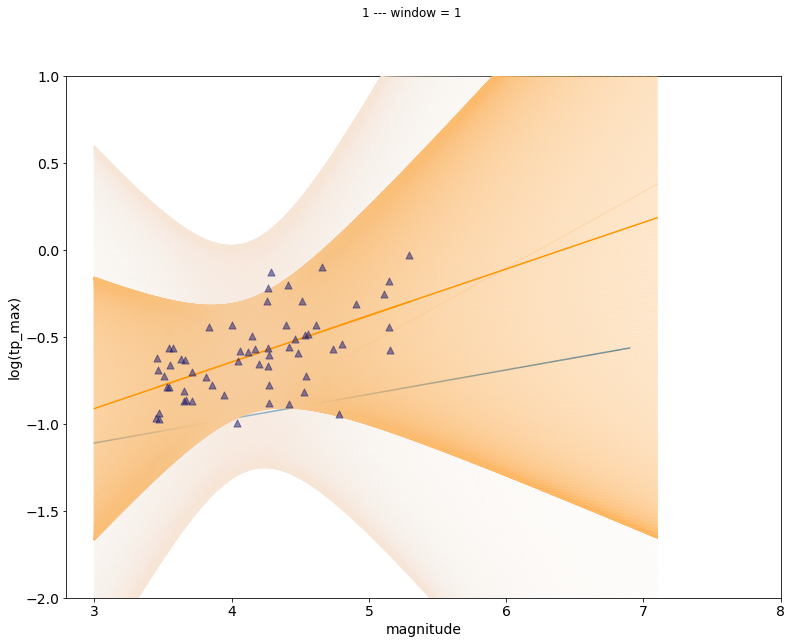

150 1.8187332868110389
1194716.632561836
1194716.635000084
try 200 92.76670218491927
os 200 127.62243611202575
3.4 [ 0.20438794 -1.45705304]
86 86
[ 0.20438794 -0.43511333] [0.17876026 0.16163965]
86


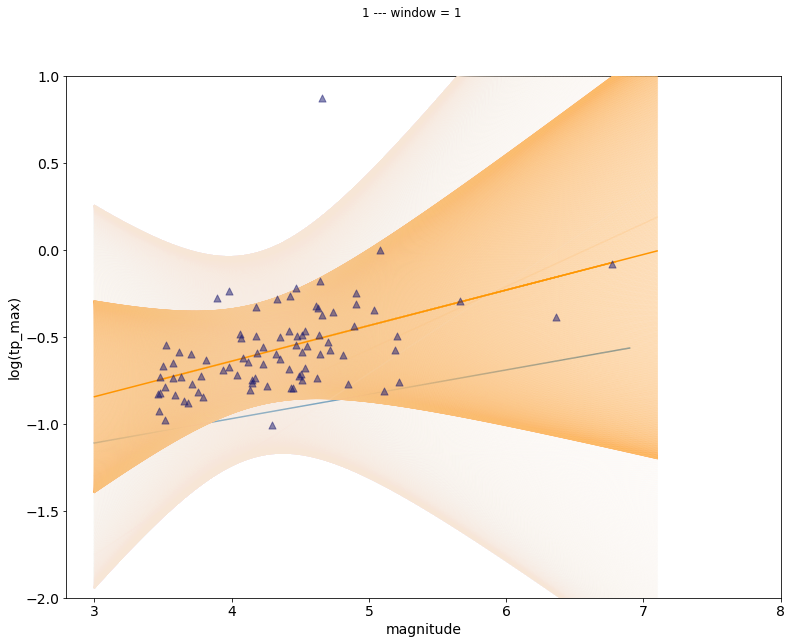

200 1.7607227938715369
1194938.793884287
1194938.796898614
try 250 125.54361875005998
os 250 129.29296053899452
3.4 [ 0.15033427 -1.2100562 ]
114 114
[ 0.15033427 -0.45838485] [0.17361801 0.15538374]
114


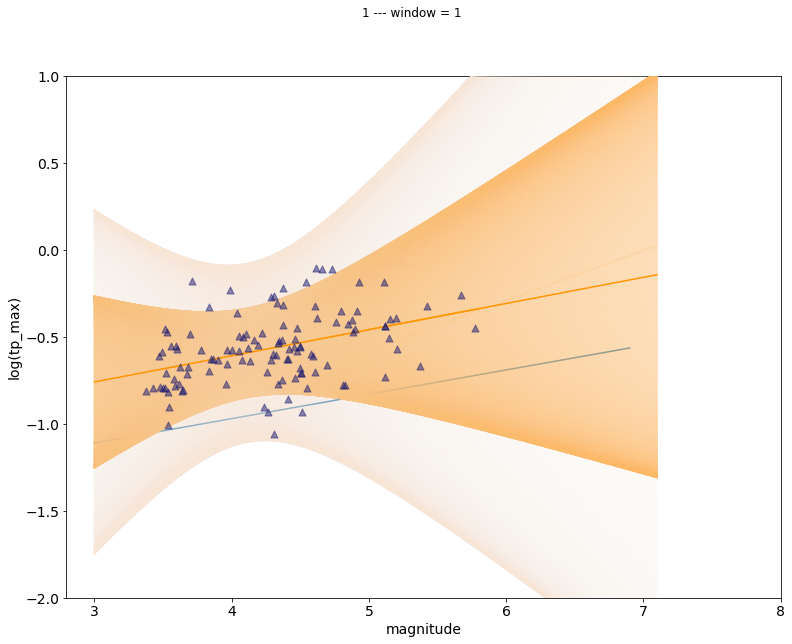

250 1.7482382161542773
1195195.390198708
1195195.393420975
try 500 201.7204500727821
os 500 250.0781292731408
3.4 [ 0.16532369 -1.28174109]
217 217
[ 0.1653237  -0.45512263] [0.14032672 0.12568497]
217


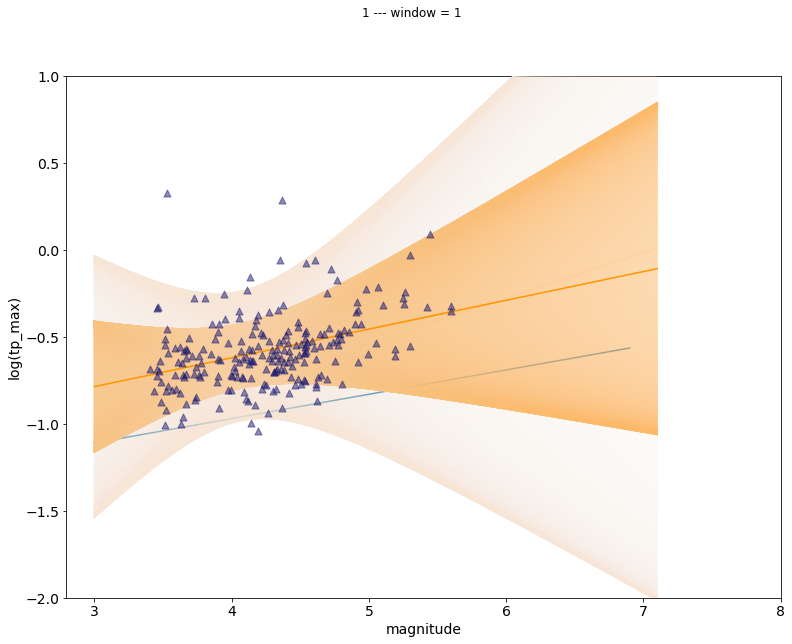

500 2.0275297400075942
1195649.227988471
1195649.230548976
try 1000 526.6515544878785
os 1000 550.2553297448903
3.4 [ 0.21286504 -1.50756702]
440 440
[ 0.21286504 -0.4432418 ] [0.08418987 0.07682909]
440


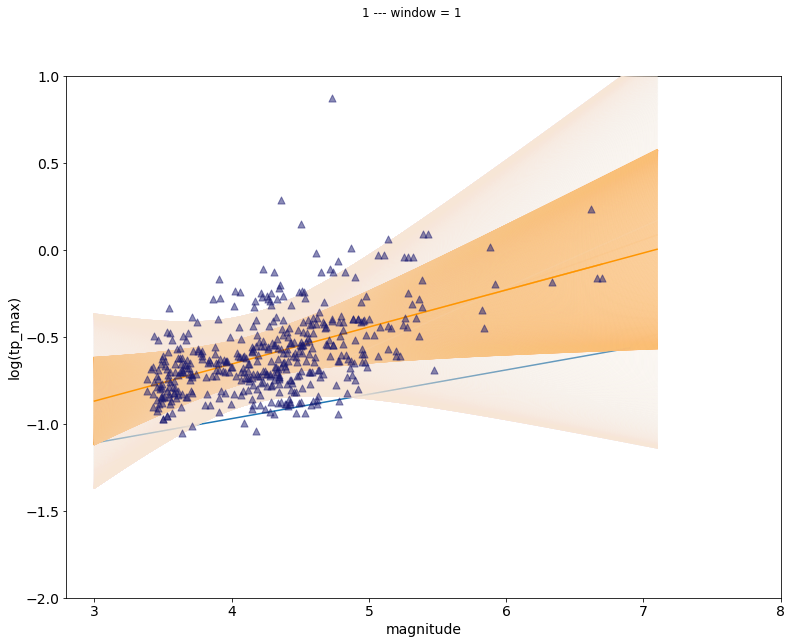

1000 2.702651738189161


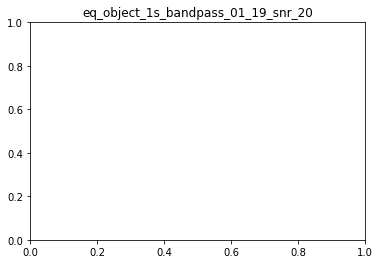

In [56]:
#for p in parameters[:1]:
for n in n_list:
    p = parameters[0]
    fn = p[-1]
    list_tpmax = []
    list_mags = []
    print(time.perf_counter())
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
    print(time.perf_counter())
    try_start = time.perf_counter()
    
    for count in range(0, n):#len(folders)):
        eq_no = random.randint(0, len(folders))#start = time.perf_counter()
        try:
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
            stop = time.perf_counter()
            #print('sucess')
            #print(stop-start)
        except Exception:
            #stop = time.perf_counter()
            #print('except')
            #print(stop-start)
            continue
    try_stop = time.perf_counter()
    t_try.append(try_stop-try_start)
    print('try',n, try_stop-try_start)
    os_start = time.perf_counter()
    for count in range(0, n):#len(folders)):
        eq_no = random.randint(0, len(folders))#start = time.perf_counter()
        #start = time.perf_counter()
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
            stop = time.perf_counter()
            #print('sucess')
            #print(stop-start)  
    os_stop = time.perf_counter()
    t_os.append(os_stop-os_start)
    print('os',n, os_stop-os_start)
    #folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
    #for eq_no in range(0, 2):#len(folders)):
    #    try:
    #        print(time.perf_counter())
    #        with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
    #            eq = pickle.load(picklefile)
    #        print(time.perf_counter())
    #        list_tpmax.append(eq.calculated_params['tau_p_max'])
    #        list_mags.append(eq.event_stats['eq_mag'])
    #        list_mag_types.append(eq.event_stats['eq_mag_type'])
    #    except Exception:
    #        continue
    plot_start = time.perf_counter()       
    plot_for_params(list_mags, list_tpmax)
    plot_stop = time.perf_counter()
    t_plot.append(plot_stop-plot_start)
    print(n, plot_stop-plot_start)
    plt.title(p[-1])

In [81]:
len(folders)

145

1204029.082826635
1204029.08321091
try 144 0.0005900759715586901
os 144 38.9701682520099
1204068.062401466
3.4 [ 0.18902437 -1.41418734]
61 61
[ 0.18902437 -0.4690655 ] [0.18505363 0.15626504]
61


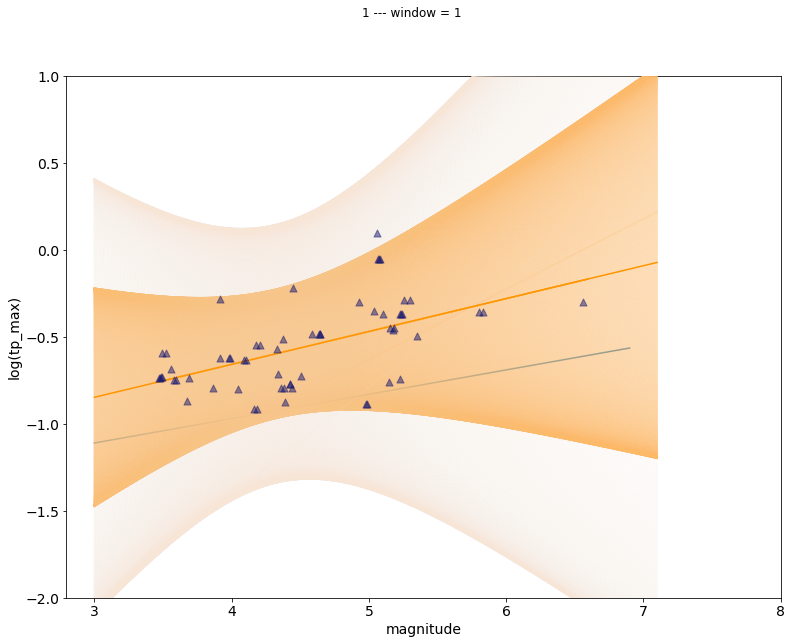

144 1.6693465667776763


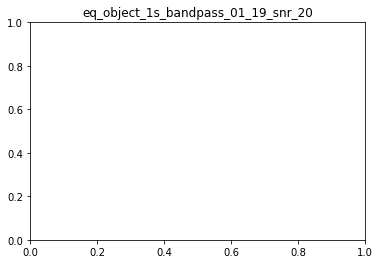

In [91]:
#for p in parameters[:1]:
n_list = [50,100,144]
n_list = [144]
for n in n_list:
    p = parameters[0]
    fn = p[-1]
    list_tpmax = []
    list_mags = []
    print(time.perf_counter())
    folders = os.listdir('/home/users/ug16g06/Documents/local_results/')
    print(time.perf_counter())
    try_start = time.perf_counter()
    for count in range(0, n):#len(folders)):
        eq_no = random.randint(0, len(folders))#start = time.perf_counter()
        try:
            with open('/home/users/ug16g06/Documents/local_results/'+folders[eq_no]+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
            stop = time.perf_counter()
            #print('sucess')
            #print(stop-start)
        except Exception:
            #stop = time.perf_counter()
            #print('except')
            #print(stop-start)
            continue
    try_stop = time.perf_counter()
    t_try.append(try_stop-try_start)
    print('try',n, try_stop-try_start)
    os_start = time.perf_counter()
    for count in range(0, n):#len(folders)):
        eq_no = random.randint(0, len(folders)-1)#start = time.perf_counter()
        #start = time.perf_counter()
        if os.path.exists('/home/users/ug16g06/Documents/local_results/'+folders[eq_no]):
            #print('exists')
            with open('/home/users/ug16g06/Documents/local_results/'+folders[eq_no], 'rb') as picklefile:
                eq = pickle.load(picklefile)
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
            stop = time.perf_counter()
            #print('sucess')
            #print(stop-start)  
    os_stop = time.perf_counter()
    t_os.append(os_stop-os_start)
    print('os',n, os_stop-os_start)
    #folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
    #for eq_no in range(0, 2):#len(folders)):
    #    try:
    #        print(time.perf_counter())
    #        with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
    #            eq = pickle.load(picklefile)
    #        print(time.perf_counter())
    #        list_tpmax.append(eq.calculated_params['tau_p_max'])
    #        list_mags.append(eq.event_stats['eq_mag'])
    #        list_mag_types.append(eq.event_stats['eq_mag_type'])
    #    except Exception:
    #        continue
    plot_start = time.perf_counter()       
    plot_for_params(list_mags, list_tpmax)
    plot_stop = time.perf_counter()
    t_plot.append(plot_stop-plot_start)
    print(n, plot_stop-plot_start)
    plt.title(p[-1])

In [90]:
eq_no

145

In [57]:
n_list = np.array(n_list)
t_plot = np.array(t_plot)
t_os = np.array(t_os)
t_try = np.array(t_try)

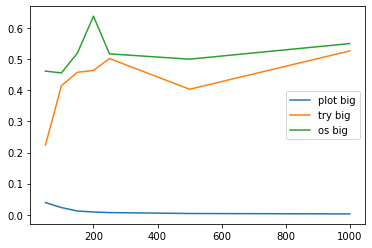

In [59]:
plt.plot(n_list, t_plot[0:7]/n_list, label = 'plot big')
plt.plot(n_list, t_try[0:7]/n_list, label = 'try big')
plt.plot(n_list, t_os[0:7]/n_list, label = 'os big')
#plt.plot(n_list, t_plot[7:], label = 'plot')
#plt.plot(n_list, t_try[7:], label = 'try')
#plt.plot(n_list, t_os[7:], label = 'os')
plt.legend()

In [61]:
a = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl'

In [62]:
a

'/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/20191002_112920.a/eq_object_1s_bandpass_01_19_snr_20.pkl'

In [92]:
import os
os.cpu_count()

16

In [93]:
start = time.perf_counter()
folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
for count in range(0, 150):#len(folders)):
    print(count)
    eq_no = random.randint(0, len(folders))#start = time.perf_counter()
    try:
        shutil.copy2('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', '/home/users/ug16g06/Documents/local_results/'+folders[eq_no]+'.pkl')
    except:
        continue
folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/')
for count in range(0, 150):#len(folders)):
    print(count)
    eq_no = random.randint(0, len(folders))#start = time.perf_counter()
    try:
        shutil.copy2('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+folders[eq_no]+'/'+fn+'.pkl', '/home/users/ug16g06/Documents/local_results/'+folders[eq_no]+'.pkl')
    except:
        continue
stop = time.perf_counter()
print(stop-start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
111.4311253130436


In [60]:
import shutil

In [67]:
shutil.copy2('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', '/home/users/ug16g06/Documents/local_results/'+folders[eq_no]+'.pkl')


'/home/users/ug16g06/Documents/local_results/20191002_112920.a.pkl'